In [20]:
import re
import string
import nltk
import spacy
import emoji
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from symspellpy.symspellpy import SymSpell, Verbosity
import contractions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

contractions
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("data/frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amrr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amrr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def clean_html_and_social(text):
    text = BeautifulSoup(text, "html.parser").get_text()

    text = re.sub(r"http\S+|www\S+|https\S+", "", text)      # URLs
    text = re.sub(r"@\w+", "", text)                         # @mentions
    text = re.sub(r"#\w+", "", text)                         # #hashtags
    text = emoji.replace_emoji(text, replace='')

    return text

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)                          # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

def correct_spelling(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    if suggestions:
        return suggestions[0].term
    return text

def tokenize_text(text):
    return nltk.word_tokenize(text)

def normalize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    lemmatized = [token.lemma_ for token in doc]
    #stemmed = [stemmer.stem(token) for token in lemmatized]
    return lemmatized

def expand_contractions(tokens):
    return [contractions.fix(token) for token in tokens]

def remove_noise(tokens):
    return [token for token in tokens if token not in stop_words and len(token) > 1]

def preprocess_pipeline(text):
    text = clean_html_and_social(text)
    text = clean_text(text)
    text = correct_spelling(text)
    tokens = tokenize_text(text)
    tokens = normalize_tokens(tokens)
    tokens = expand_contractions(tokens)
    tokens = remove_noise(tokens)
    return tokens


In [16]:
sample_text = """
<p>Hello wrld!!!</p> 
Visit NLP https://example.com 😎 
@john says #amazing!!!
"""

processed_tokens = preprocess_pipeline(sample_text)

print("Original Text:\n", sample_text)
print("Processed Tokens:\n", processed_tokens)


Original Text:
 
<p>Hello wrld!!!</p> 
Visit NLP https://example.com 😎 
@john says #amazing!!!

Processed Tokens:
 ['hello', 'world', 'visit', 'nip', 'say']


In [23]:
import pandas as pd

url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'text'])
print(df.head())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


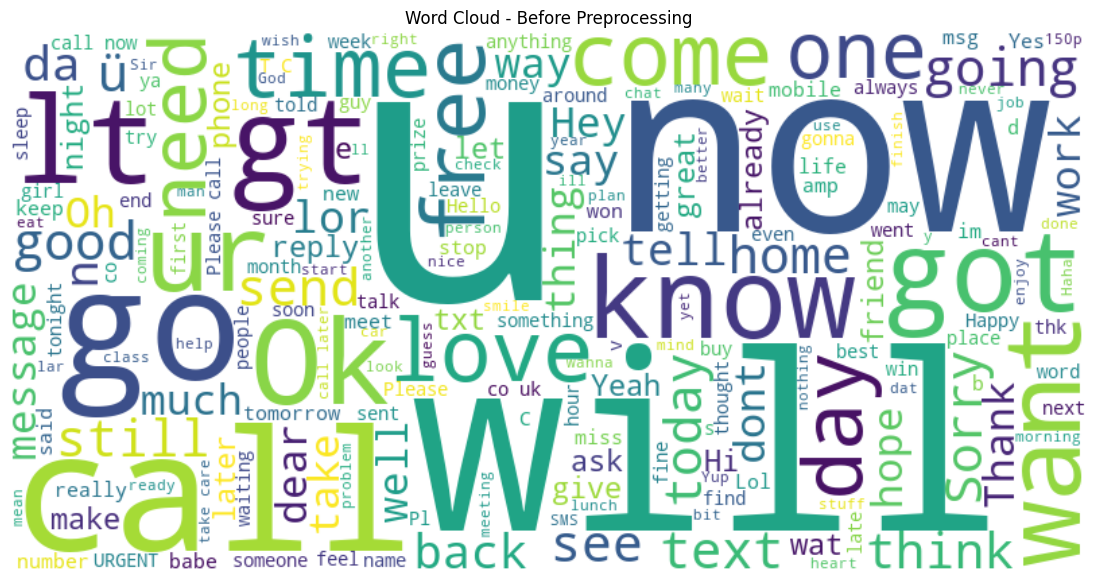

In [24]:
text_corpus = " ".join(df['text'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Before Preprocessing")
plt.show()


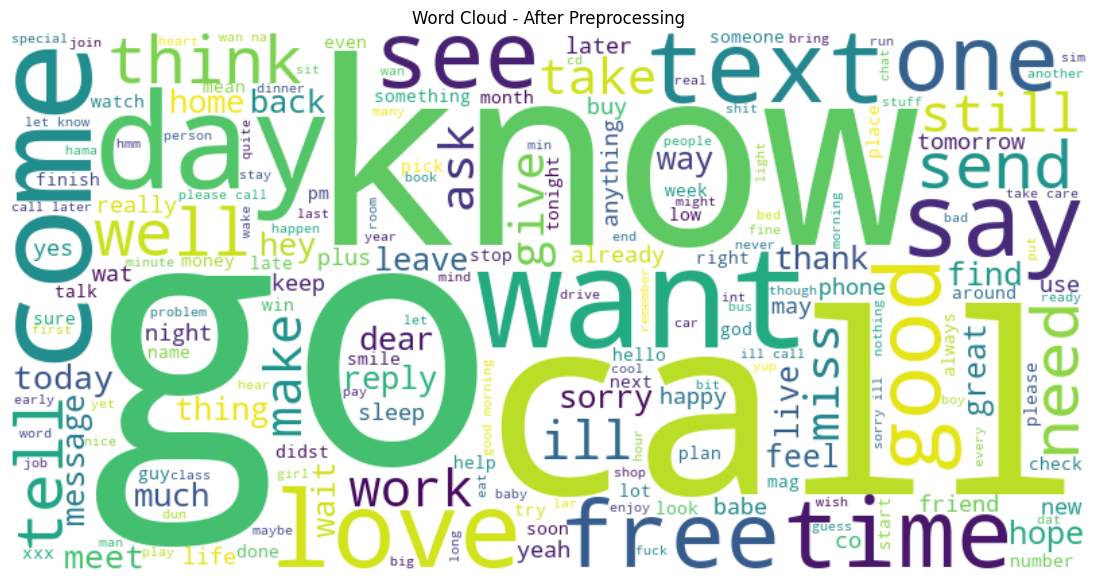

In [31]:
# Preprocess the entire dataset
df['processed_text'] = df['text'].apply(lambda x: " ".join(preprocess_pipeline(x)))
processed_corpus = " ".join(df['processed_text'].values)
preprocessed_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_corpus)
plt.figure(figsize=(15, 7))
plt.imshow(preprocessed_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - After Preprocessing")
plt.show()


In [32]:
vocabulary_size = len(set(text_corpus.split()))
print(f"Vocabulary Size before Preprocessing: {vocabulary_size}")

processed_vocabulary_size = len(set(processed_corpus.split()))
print(f"Vocabulary Size after Preprocessing: {processed_vocabulary_size}")

Vocabulary Size before Preprocessing: 15691
Vocabulary Size after Preprocessing: 5037


In [33]:
tfidf_raw = TfidfVectorizer(max_features=5000)
X_raw = tfidf_raw.fit_transform(df['text'])

tfidf_processed = TfidfVectorizer(max_features=5000)
X_processed = tfidf_processed.fit_transform(df['processed_text'])

print("Raw shape:", X_raw.shape)
print("Processed shape:", X_processed.shape)


Raw shape: (5572, 5000)
Processed shape: (5572, 5000)


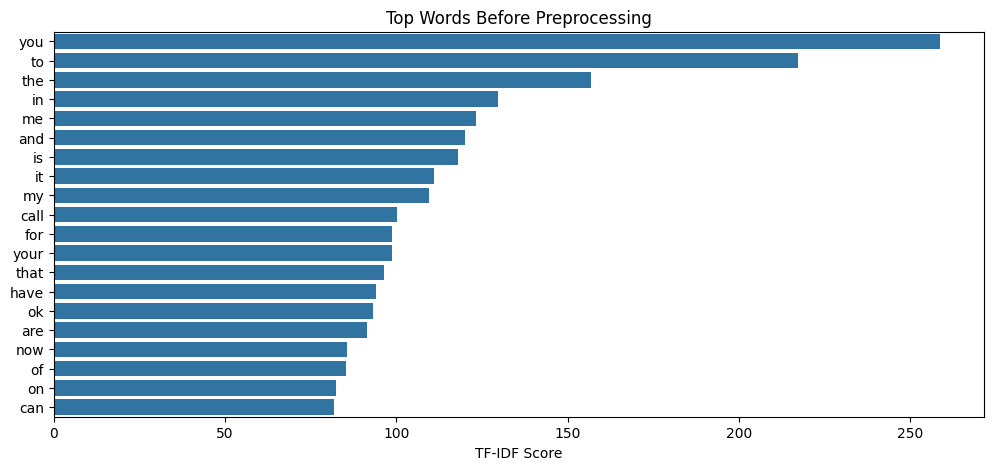

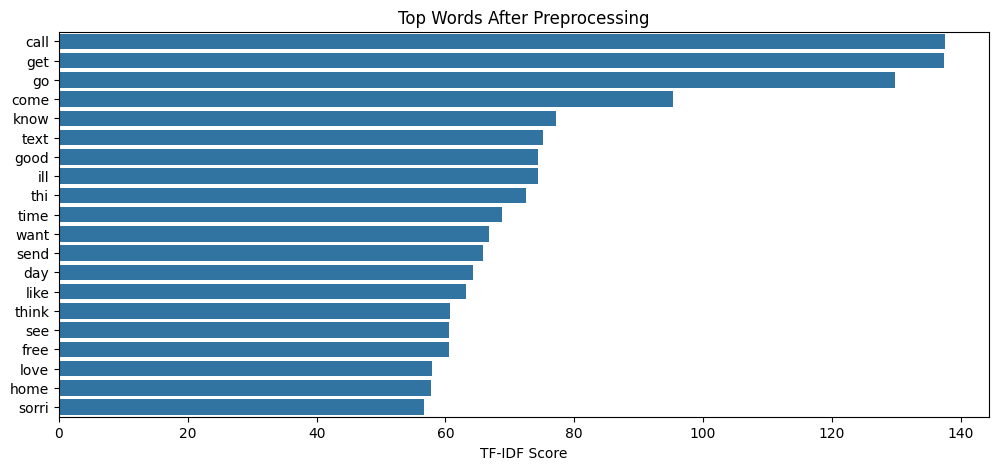

In [29]:
def plot_top_words(vectorizer, X, title, n=20):
    sums = X.sum(axis=0)
    words_freq = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    words, freqs = zip(*words_freq)

    plt.figure(figsize=(12,5))
    sns.barplot(x=list(freqs), y=list(words))
    plt.title(title)
    plt.xlabel('TF-IDF Score')
    plt.show()

plot_top_words(tfidf_raw, X_raw, "Top Words Before Preprocessing")
plot_top_words(tfidf_processed, X_processed, "Top Words After Preprocessing")


In [38]:
# tf-idf top word for the index 0 document
feature_names = tfidf_processed.get_feature_names_out()
first_doc_vector = X_processed[1]
top_n = 10
sorted_items = np.argsort(first_doc_vector.toarray()).flatten()[::-1]
top_n_indices = sorted_items[:top_n]
top_n_words = [(feature_names[i], first_doc_vector[0, i]) for i in top_n_indices]
print("Top words in the first document after preprocessing:")
for word, score in top_n_words:
    print(f"{word}: {score:.4f}")

# before preprocessing
feature_names_raw = tfidf_raw.get_feature_names_out()
first_doc_vector_raw = X_raw[1]
top_n_indices_raw = np.argsort(first_doc_vector_raw.toarray()).flatten()[::-1][:top_n]
top_n_words_raw = [(feature_names_raw[i], first_doc_vector_raw[0, i]) for i in top_n_indices_raw]
print("\nTop words in the first document before preprocessing:")
for word, score in top_n_words_raw:
    print(f"{word}: {score:.4f}")

Top words in the first document after preprocessing:
joke: 0.6171
wife: 0.5686
lar: 0.5440
youth: 0.0000
young: 0.0000
actual: 0.0000
yak: 0.0000
accenture: 0.0000
accept: 0.0000
yup: 0.0000

Top words in the first document before preprocessing:
oni: 0.5466
joking: 0.5237
wif: 0.4316
lar: 0.4083
ok: 0.2719
zed: 0.0000
zebra: 0.0000
zealand: 0.0000
0800: 0.0000
you: 0.0000
